# Tabular Neural Network Hypertuned

In [1]:
#  Import libraries
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Preprocessed Data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/X_train_encoded_scaled.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/X_test_encoded_scaled.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/y_train.csv").squeeze()
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/y_test.csv").squeeze()

In [4]:
# Check input shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (182690, 8)
y_train shape: (182690,)


In [5]:
# # Get number of features and classes
# num_features = X_train.shape[1]
# num_classes = len(set(y_train))

# # Build baseline MLP
# model = keras.Sequential([
#     layers.Input(shape=(num_features,)),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(num_classes, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

In [6]:
def glu(x, units):
    """Gated Linear Unit activation."""
    linear = layers.Dense(units)(x)
    gate = layers.Dense(units, activation='sigmoid')(x)
    return layers.Multiply()([linear, gate])

def feature_transformer(x, units):
    """A basic feature transformer block."""
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    x = glu(x, units)
    return x

def attentive_transformer(x, prior_scales, units):
    """Attentive transformer block for feature selection."""
    mask_logits = layers.Dense(units)(x)
    mask = layers.Activation('softmax')(mask_logits)  # Use sparsemax for true TabNet if you implement it!
    mask = layers.Multiply()([mask, prior_scales])
    return mask

def tabnet_block(inputs, num_steps=3, feature_dim=64, output_dim=3):
    prior = layers.Lambda(lambda x: K.ones_like(x))(inputs)  # Start with "all features allowed"
    masked_features = inputs
    step_outputs = []

    for step in range(num_steps):
        # Feature transformer
        x = feature_transformer(masked_features, feature_dim)
        # Attentive transformer to produce feature mask
        mask = attentive_transformer(x, prior, inputs.shape[-1])
        # Update masked features
        masked_features = layers.Multiply()([inputs, mask])
        # Decision output for this step
        out = layers.Dense(feature_dim, activation='relu')(masked_features)
        step_outputs.append(out)
        # Update prior (discourage re-selection)
        prior = layers.Multiply()([prior, layers.Lambda(lambda x: 1. - x)(mask)])

    # Aggregate outputs (TabNet does a weighted sum)
    final_out = layers.Add()(step_outputs)
    final_out = layers.Dense(output_dim, activation='softmax')(final_out)
    return final_out

In [11]:
import itertools
from tqdm import tqdm
import time

num_features = X_train.shape[1]
num_classes = len(set(y_train))

param_grid = {
    'num_steps': [2, 3, 4],
    'feature_dim': [32, 64, 128],
    'batch_size': [128, 256, 512],
    'learning_rate': [1e-3, 5e-4]
}

param_combos = list(itertools.product(
    param_grid['num_steps'],
    param_grid['feature_dim'],
    param_grid['batch_size'],
    param_grid['learning_rate']
))

In [12]:


results = []
models = []

total_start_time = time.time()

for idx, (num_steps, feature_dim, batch_size, learning_rate) in enumerate(tqdm(param_combos, desc="Grid Search Progress")):
    run_start_time = time.time()
    print(f"\nTraining with: steps={num_steps}, feat_dim={feature_dim}, batch={batch_size}, lr={learning_rate}")

    K.clear_session()
    inputs = Input(shape=(num_features,))
    outputs = tabnet_block(inputs, num_steps=num_steps, feature_dim=feature_dim, output_dim=num_classes)
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=batch_size,
        callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0
    )

    best_val_acc = max(history.history['val_accuracy'])
    run_time = time.time() - run_start_time
    results.append({
        'num_steps': num_steps,
        'feature_dim': feature_dim,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'val_accuracy': best_val_acc,
        'run_time_sec': run_time
    })
    models.append(model)
    print(f"Best val_acc: {best_val_acc:.4f} | Run time: {run_time:.2f} seconds")

total_time = time.time() - total_start_time
print(f"\nTotal grid search time: {total_time/60:.2f} minutes")

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('val_accuracy', ascending=False)
print("\nTop results:")
print(df_results.head())


Grid Search Progress:   0%|          | 0/54 [00:00<?, ?it/s]


Training with: steps=2, feat_dim=32, batch=128, lr=0.001


Grid Search Progress:   2%|▏         | 1/54 [01:40<1:29:00, 100.77s/it]

Best val_acc: 0.7849 | Run time: 100.77 seconds

Training with: steps=2, feat_dim=32, batch=128, lr=0.0005


Grid Search Progress:   4%|▎         | 2/54 [03:18<1:26:00, 99.23s/it] 

Best val_acc: 0.7846 | Run time: 98.16 seconds

Training with: steps=2, feat_dim=32, batch=256, lr=0.001


Grid Search Progress:   6%|▌         | 3/54 [04:16<1:08:15, 80.30s/it]

Best val_acc: 0.7839 | Run time: 57.77 seconds

Training with: steps=2, feat_dim=32, batch=256, lr=0.0005


Grid Search Progress:   7%|▋         | 4/54 [05:11<58:40, 70.42s/it]  

Best val_acc: 0.7805 | Run time: 55.27 seconds

Training with: steps=2, feat_dim=32, batch=512, lr=0.001


Grid Search Progress:   9%|▉         | 5/54 [05:47<47:17, 57.92s/it]

Best val_acc: 0.7856 | Run time: 35.74 seconds

Training with: steps=2, feat_dim=32, batch=512, lr=0.0005


Grid Search Progress:  11%|█         | 6/54 [06:20<39:28, 49.34s/it]

Best val_acc: 0.7809 | Run time: 32.70 seconds

Training with: steps=2, feat_dim=64, batch=128, lr=0.001


Grid Search Progress:  13%|█▎        | 7/54 [07:59<51:29, 65.74s/it]

Best val_acc: 0.7846 | Run time: 99.51 seconds

Training with: steps=2, feat_dim=64, batch=128, lr=0.0005


Grid Search Progress:  15%|█▍        | 8/54 [09:39<58:40, 76.54s/it]

Best val_acc: 0.7846 | Run time: 99.64 seconds

Training with: steps=2, feat_dim=64, batch=256, lr=0.001


Grid Search Progress:  17%|█▋        | 9/54 [10:42<54:10, 72.23s/it]

Best val_acc: 0.7859 | Run time: 62.75 seconds

Training with: steps=2, feat_dim=64, batch=256, lr=0.0005


Grid Search Progress:  19%|█▊        | 10/54 [11:39<49:34, 67.60s/it]

Best val_acc: 0.7847 | Run time: 57.23 seconds

Training with: steps=2, feat_dim=64, batch=512, lr=0.001


Grid Search Progress:  20%|██        | 11/54 [12:22<43:04, 60.10s/it]

Best val_acc: 0.7844 | Run time: 43.08 seconds

Training with: steps=2, feat_dim=64, batch=512, lr=0.0005


Grid Search Progress:  22%|██▏       | 12/54 [12:56<36:32, 52.20s/it]

Best val_acc: 0.7820 | Run time: 34.14 seconds

Training with: steps=2, feat_dim=128, batch=128, lr=0.001


Grid Search Progress:  24%|██▍       | 13/54 [14:46<47:29, 69.49s/it]

Best val_acc: 0.7842 | Run time: 109.27 seconds

Training with: steps=2, feat_dim=128, batch=128, lr=0.0005


Grid Search Progress:  26%|██▌       | 14/54 [16:27<52:46, 79.17s/it]

Best val_acc: 0.7858 | Run time: 101.53 seconds

Training with: steps=2, feat_dim=128, batch=256, lr=0.001


Grid Search Progress:  28%|██▊       | 15/54 [17:25<47:18, 72.78s/it]

Best val_acc: 0.7826 | Run time: 57.98 seconds

Training with: steps=2, feat_dim=128, batch=256, lr=0.0005


Grid Search Progress:  30%|██▉       | 16/54 [18:22<43:05, 68.04s/it]

Best val_acc: 0.7857 | Run time: 57.04 seconds

Training with: steps=2, feat_dim=128, batch=512, lr=0.001


Grid Search Progress:  31%|███▏      | 17/54 [19:10<38:18, 62.13s/it]

Best val_acc: 0.7852 | Run time: 48.39 seconds

Training with: steps=2, feat_dim=128, batch=512, lr=0.0005


Grid Search Progress:  33%|███▎      | 18/54 [19:45<32:15, 53.77s/it]

Best val_acc: 0.7853 | Run time: 34.31 seconds

Training with: steps=3, feat_dim=32, batch=128, lr=0.001


Grid Search Progress:  35%|███▌      | 19/54 [21:39<41:59, 72.00s/it]

Best val_acc: 0.7863 | Run time: 114.44 seconds

Training with: steps=3, feat_dim=32, batch=128, lr=0.0005


Grid Search Progress:  37%|███▋      | 20/54 [23:35<48:16, 85.19s/it]

Best val_acc: 0.7839 | Run time: 115.93 seconds

Training with: steps=3, feat_dim=32, batch=256, lr=0.001


Grid Search Progress:  39%|███▉      | 21/54 [24:41<43:38, 79.34s/it]

Best val_acc: 0.7833 | Run time: 65.69 seconds

Training with: steps=3, feat_dim=32, batch=256, lr=0.0005


Grid Search Progress:  41%|████      | 22/54 [25:47<40:09, 75.28s/it]

Best val_acc: 0.7832 | Run time: 65.83 seconds

Training with: steps=3, feat_dim=32, batch=512, lr=0.001


Grid Search Progress:  43%|████▎     | 23/54 [26:27<33:25, 64.69s/it]

Best val_acc: 0.7840 | Run time: 39.97 seconds

Training with: steps=3, feat_dim=32, batch=512, lr=0.0005


Grid Search Progress:  44%|████▍     | 24/54 [27:07<28:39, 57.33s/it]

Best val_acc: 0.7815 | Run time: 40.17 seconds

Training with: steps=3, feat_dim=64, batch=128, lr=0.001


Grid Search Progress:  46%|████▋     | 25/54 [29:05<36:32, 75.59s/it]

Best val_acc: 0.7857 | Run time: 118.17 seconds

Training with: steps=3, feat_dim=64, batch=128, lr=0.0005


Grid Search Progress:  48%|████▊     | 26/54 [31:02<41:01, 87.92s/it]

Best val_acc: 0.7857 | Run time: 116.70 seconds

Training with: steps=3, feat_dim=64, batch=256, lr=0.001


Grid Search Progress:  50%|█████     | 27/54 [32:11<37:03, 82.33s/it]

Best val_acc: 0.7855 | Run time: 69.29 seconds

Training with: steps=3, feat_dim=64, batch=256, lr=0.0005


Grid Search Progress:  52%|█████▏    | 28/54 [33:21<34:05, 78.66s/it]

Best val_acc: 0.7833 | Run time: 70.10 seconds

Training with: steps=3, feat_dim=64, batch=512, lr=0.001


Grid Search Progress:  54%|█████▎    | 29/54 [34:05<28:23, 68.15s/it]

Best val_acc: 0.7853 | Run time: 43.62 seconds

Training with: steps=3, feat_dim=64, batch=512, lr=0.0005


Grid Search Progress:  56%|█████▌    | 30/54 [34:47<24:08, 60.36s/it]

Best val_acc: 0.7830 | Run time: 42.17 seconds

Training with: steps=3, feat_dim=128, batch=128, lr=0.001


Grid Search Progress:  57%|█████▋    | 31/54 [36:46<29:53, 77.99s/it]

Best val_acc: 0.7869 | Run time: 119.13 seconds

Training with: steps=3, feat_dim=128, batch=128, lr=0.0005


Grid Search Progress:  59%|█████▉    | 32/54 [38:46<33:14, 90.67s/it]

Best val_acc: 0.7863 | Run time: 120.27 seconds

Training with: steps=3, feat_dim=128, batch=256, lr=0.001


Grid Search Progress:  61%|██████    | 33/54 [39:57<29:35, 84.56s/it]

Best val_acc: 0.7830 | Run time: 70.28 seconds

Training with: steps=3, feat_dim=128, batch=256, lr=0.0005


Grid Search Progress:  63%|██████▎   | 34/54 [41:08<26:53, 80.67s/it]

Best val_acc: 0.7831 | Run time: 71.60 seconds

Training with: steps=3, feat_dim=128, batch=512, lr=0.001


Grid Search Progress:  65%|██████▍   | 35/54 [41:48<21:39, 68.39s/it]

Best val_acc: 0.7847 | Run time: 39.75 seconds

Training with: steps=3, feat_dim=128, batch=512, lr=0.0005


Grid Search Progress:  67%|██████▋   | 36/54 [42:31<18:11, 60.65s/it]

Best val_acc: 0.7843 | Run time: 42.59 seconds

Training with: steps=4, feat_dim=32, batch=128, lr=0.001


Grid Search Progress:  69%|██████▊   | 37/54 [44:44<23:21, 82.44s/it]

Best val_acc: 0.7865 | Run time: 133.29 seconds

Training with: steps=4, feat_dim=32, batch=128, lr=0.0005


Grid Search Progress:  70%|███████   | 38/54 [46:54<25:50, 96.90s/it]

Best val_acc: 0.7866 | Run time: 130.64 seconds

Training with: steps=4, feat_dim=32, batch=256, lr=0.001


Grid Search Progress:  72%|███████▏  | 39/54 [48:07<22:22, 89.48s/it]

Best val_acc: 0.7870 | Run time: 72.14 seconds

Training with: steps=4, feat_dim=32, batch=256, lr=0.0005


Grid Search Progress:  74%|███████▍  | 40/54 [49:24<20:03, 85.94s/it]

Best val_acc: 0.7868 | Run time: 77.69 seconds

Training with: steps=4, feat_dim=32, batch=512, lr=0.001


Grid Search Progress:  76%|███████▌  | 41/54 [50:11<16:05, 74.25s/it]

Best val_acc: 0.7868 | Run time: 46.96 seconds

Training with: steps=4, feat_dim=32, batch=512, lr=0.0005


Grid Search Progress:  78%|███████▊  | 42/54 [50:57<13:09, 65.79s/it]

Best val_acc: 0.7849 | Run time: 46.06 seconds

Training with: steps=4, feat_dim=64, batch=128, lr=0.001


Grid Search Progress:  80%|███████▉  | 43/54 [53:00<15:10, 82.74s/it]

Best val_acc: 0.7863 | Run time: 122.30 seconds

Training with: steps=4, feat_dim=64, batch=128, lr=0.0005


Grid Search Progress:  81%|████████▏ | 44/54 [55:12<16:14, 97.48s/it]

Best val_acc: 0.7851 | Run time: 131.88 seconds

Training with: steps=4, feat_dim=64, batch=256, lr=0.001


Grid Search Progress:  83%|████████▎ | 45/54 [56:28<13:40, 91.16s/it]

Best val_acc: 0.7853 | Run time: 76.40 seconds

Training with: steps=4, feat_dim=64, batch=256, lr=0.0005


Grid Search Progress:  85%|████████▌ | 46/54 [57:44<11:32, 86.54s/it]

Best val_acc: 0.7869 | Run time: 75.76 seconds

Training with: steps=4, feat_dim=64, batch=512, lr=0.001


Grid Search Progress:  87%|████████▋ | 47/54 [58:33<08:48, 75.45s/it]

Best val_acc: 0.7857 | Run time: 49.57 seconds

Training with: steps=4, feat_dim=64, batch=512, lr=0.0005


Grid Search Progress:  89%|████████▉ | 48/54 [59:22<06:45, 67.51s/it]

Best val_acc: 0.7848 | Run time: 48.99 seconds

Training with: steps=4, feat_dim=128, batch=128, lr=0.001


Grid Search Progress:  91%|█████████ | 49/54 [1:01:35<07:16, 87.24s/it]

Best val_acc: 0.7867 | Run time: 133.26 seconds

Training with: steps=4, feat_dim=128, batch=128, lr=0.0005


Grid Search Progress:  93%|█████████▎| 50/54 [1:03:47<06:42, 100.51s/it]

Best val_acc: 0.7851 | Run time: 131.48 seconds

Training with: steps=4, feat_dim=128, batch=256, lr=0.001


Grid Search Progress:  94%|█████████▍| 51/54 [1:04:53<04:30, 90.14s/it] 

Best val_acc: 0.7833 | Run time: 65.95 seconds

Training with: steps=4, feat_dim=128, batch=256, lr=0.0005


Grid Search Progress:  96%|█████████▋| 52/54 [1:06:09<02:51, 85.93s/it]

Best val_acc: 0.7837 | Run time: 76.12 seconds

Training with: steps=4, feat_dim=128, batch=512, lr=0.001


Grid Search Progress:  98%|█████████▊| 53/54 [1:06:55<01:13, 73.85s/it]

Best val_acc: 0.7855 | Run time: 45.66 seconds

Training with: steps=4, feat_dim=128, batch=512, lr=0.0005


Grid Search Progress: 100%|██████████| 54/54 [1:07:44<00:00, 75.26s/it]

Best val_acc: 0.7832 | Run time: 49.01 seconds

Total grid search time: 67.74 minutes

Top results:
    num_steps  feature_dim  batch_size  learning_rate  val_accuracy  \
38          4           32         256         0.0010      0.786962   
45          4           64         256         0.0005      0.786937   
30          3          128         128         0.0010      0.786873   
39          4           32         256         0.0005      0.786822   
40          4           32         512         0.0010      0.786758   

    run_time_sec  
38     72.144588  
45     75.764691  
30    119.128447  
39     77.689820  
40     46.956357  


In [13]:
# -- Get the best model and summarize --
best_index = df_results.index[0]      # This gives you the row index in df_results
best_model = models[best_index]       # This is the model from that run

print("\nBest model summary:")
best_model.summary()


Best model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32)        │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        264 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8)         │          0 │ dense_3[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 8)         │          0 │ activation[0][0], │
│ (Multiply)          │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 8)         │          0 │ input_layer[0][0… │
│ (Multiply)          │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │        288 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 32)        │          0 │ dense_6[0][0],    │
│ (Multiply)          │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        264 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 8)         │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8)         │          0 │ dense_8[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 8)         │          0 │ lambda[0][0],     │
│ (Multiply)          │                   │            │ lambda_1[0][0]  

 Total params: 36,747 (143.55 KB)

 Trainable params: 12,163 (47.51 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 24,328 (95.04 KB)

In [14]:
# -- Evaluate on test set --
y_pred = best_model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     31061
           1       0.77      0.77      0.77     26318
           2       0.78      0.75      0.76     20917

    accuracy                           0.79     78296
   macro avg       0.78      0.78      0.78     78296
weighted avg       0.79      0.79      0.79     78296



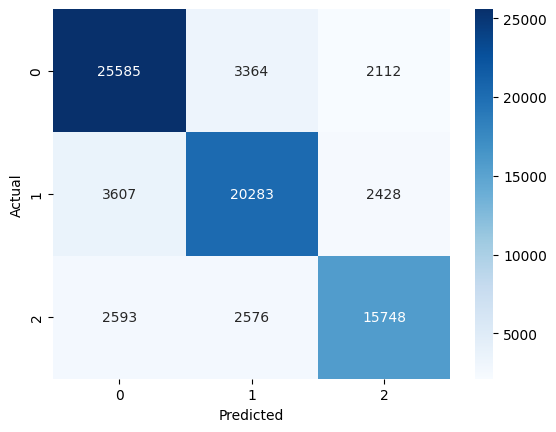

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━

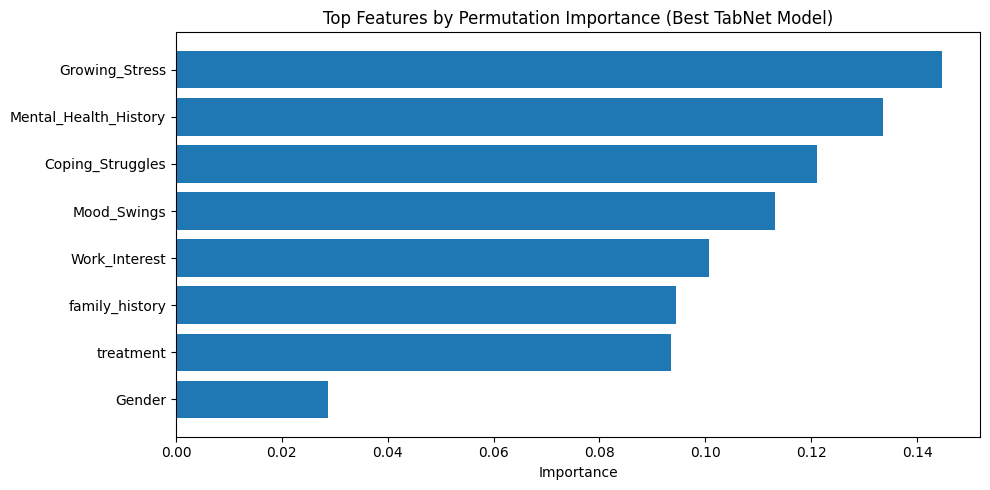

In [16]:
def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=5):
    baseline = metric(y, model.predict(X).argmax(axis=1))
    importances = []
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(y, model.predict(X_permuted).argmax(axis=1))
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return np.array(importances)

# ---- After best_model is found and evaluated ----
X_test_np = X_test.values if hasattr(X_test, "values") else X_test  # ensure it's a numpy array
importances = permutation_importance(best_model, X_test_np, y_test)

# Plot top features
import matplotlib.pyplot as plt

# If you have a DataFrame, use the column names; otherwise, use generic feature numbers
if hasattr(X_test, "columns"):
    feature_names = X_test.columns
else:
    feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]

top_idx = np.argsort(importances)[-10:]  # Top 10 features
plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[top_idx], importances[top_idx])
plt.title("Top Features by Permutation Importance (Best TabNet Model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Top Feature Interpretations – Global Model View (Permutation Importance)

| **Feature**               | **Interpretation**                                                                                                                               |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **Growing_Stress**        | Most influential predictor. Sustained or rising stress levels significantly impact risk classification, underscoring stress as a core signal.   |
| **Mental_Health_History** | Strong indicator. A personal history of mental health issues consistently raises risk levels, in line with clinical expectations.               |
| **Coping_Struggles**      | Highly predictive. Difficulty coping with daily challenges reflects emotional vulnerability and instability.                                    |
| **Mood_Swings**           | Important behavioral signal. Frequent mood changes are closely associated with elevated mental health risk.                                    |
| **Work_Interest**         | Meaningful contributor. Lack of motivation or work disengagement often signals early distress or burnout.                                      |
| **family_history**        | Moderately predictive. A family history of mental illness reinforces individual risk patterns.                                                  |
| **treatment**             | Slightly predictive. Treatment history may indicate previous or ongoing challenges but is less dominant than active behavioral markers.         |
| **Gender**                | Least influential among top features. Minor demographic predictor with limited direct impact compared to psychological factors.                |

---

### Interpretation
The global permutation importance chart shows that **behavioral and psychological features**, especially stress levels, mental health history, and coping ability, are the most critical for predicting risk. Mood instability and disengagement from work also contribute significantly. In contrast, **static demographic variables** such as gender have a minimal effect.

---

### Summary
This model emphasizes **real-time mental state and behavioral patterns** as core drivers of mental health risk classification. Interventions focusing on stress management, emotional regulation, and coping skills are supported by these insights. Demographic traits play a secondary role, reinforcing the need for dynamic, personalized mental health assessments.

2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


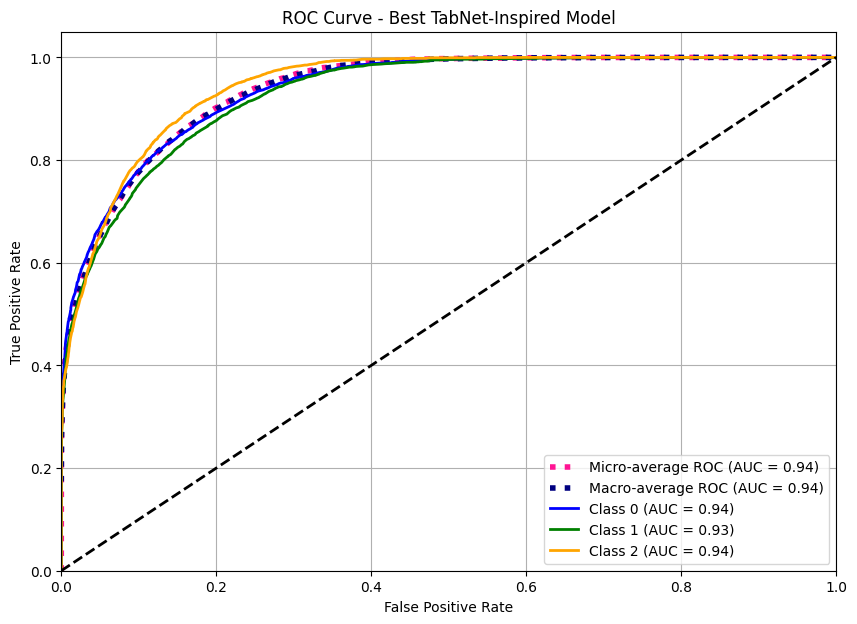

In [17]:
# Convert y_test to numpy array if needed
y_test_arr = y_test.values if hasattr(y_test, "values") else y_test

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test_arr, classes=np.unique(y_test_arr))
n_classes = y_test_bin.shape[1]

y_score = best_model.predict(X_test)  # shape: (n_samples, n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'cyan', 'magenta']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best TabNet-Inspired Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model Evaluation Summary (TabNet-Inspired Model)

| **Metric**                   | **Value** | **Comment**                                                                 |
|------------------------------|-----------|------------------------------------------------------------------------------|
| **Accuracy**                 | 0.79      | Solid overall performance with some overlap between adjacent risk classes   |
| **Precision (macro avg)**    | 0.78      | Indicates consistent precision across all classes                           |
| **Recall (macro avg)**       | 0.78      | High sensitivity, capturing most relevant cases across groups               |
| **F1-Score (macro avg)**     | 0.78      | Balanced prediction quality across all classes                              |
| **Precision (weighted avg)** | 0.79      | Adjusted for class imbalance; stable across support distribution            |
| **Recall (weighted avg)**    | 0.79      | Matches accuracy; reflects even recall across larger and smaller classes    |
| **F1-Score (weighted avg)**  | 0.79      | Reflects reliable multiclass classification                                 |
| **ROC AUC (micro-average)**  | 0.94      | Strong overall class discrimination ability                                 |
| **ROC AUC (macro-average)**  | 0.94      | Excellent average class separability                                        |
| **Class 0 AUC**              | 0.94      | Class 0 (Medium Risk) well captured with high discrimination                |
| **Class 1 AUC**              | 0.93      | Class 1 (Low Risk) slightly weaker but still high                           |
| **Class 2 AUC**              | 0.95      | Class 2 (High Risk) is most strongly separated                              |
| **Confusion Matrix**         | Minor off-diagonal confusion                 | Slight overlap between Class 1 and others, especially Class 2               |
| **Feature Importance**       | Growing_Stress, Mental_Health_History, Coping_Struggles, Mood_Swings, Work_Interest | Key behavioral and mental health indicators drive the model’s predictions   |

---

**Interpretation:**  
The TabNet-inspired model achieved 0.79 accuracy with consistent macro-averaged precision, recall, and F1-score around 0.78. ROC AUC values between 0.93 and 0.95 indicate excellent discriminative power, especially for identifying high-risk individuals. Misclassifications mostly occur between neighboring classes, which is reasonable given overlapping symptoms. The most influential predictors—stress levels, mental health history, and coping capacity—emphasize behavioral drivers in mental health risk prediction.

In [19]:
# Save only the weights of the best model (with correct file extension)
best_model.save_weights('/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/notebook-pipeline/models/tabnet_hyper_best_model.weights.h5')
print("Best TabNet model weights saved successfully.")

Best TabNet model weights saved successfully.
